In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data  import random_split, Subset
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import torchvision.transforms as T
import matplotlib.pyplot as plt
import time
import copy

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

%load_ext autoreload
%autoreload 2

In [2]:
from model.data_loader import *

PHOTOSHOPS_SMALL ='data/photoshops_small'
ORIGINALS_SMALL ='data/originals_small'


In [3]:
master_dataset = PhotoshopDataset(ORIGINALS_SMALL, PHOTOSHOPS_SMALL)
print(len(master_dataset))

5902


Change device to GPU if available

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Create train, val, splits for full learning 

This is the dataset that will be used for final learning

In [5]:
random.seed(42)

n = len(master_dataset)
n_test= int( n * .15 )  # number of test/val elements
n_val = n_test
n_train = n - 2 * n_test

train_set, val_set, test_set = random_split(master_dataset, (n_train, n_val, n_test))

In [6]:
print (len(train_set))
train_set.transform = data_transforms['train']
print (len(val_set))
val_set.transform = data_transforms['val']
print (len(test_set))
test_set.transform = data_transforms['val']

4132
885
885


### Create train, val, splits for dev

This is the dataset that will be used for development i.e 10% of master data

In [7]:
n_train_dev = int( n_train * .10 )
n_test_dev= int( n_test * .10 )  
n_val_dev = int( n_val * .10 )


train_set_dev = Subset(train_set, range(n_train_dev-1))
val_set_dev = Subset(val_set,range(n_val_dev))
test_set_dev = Subset(test_set, range(n_test_dev))

In [8]:
print (len(train_set_dev))
print (len(val_set_dev))
print (len(test_set_dev))

412
88
88


### Create data loaders for dev sets

Used to load data. 

In [9]:
full_dataloaders = {
    'train' : DataLoader(train_set, batch_size=128, shuffle=True, num_workers=4),
    'val' : DataLoader(val_set, batch_size=128, shuffle=True, num_workers=4),
    'test' : DataLoader(test_set, batch_size=128, shuffle=True, num_workers=4),
}

In [10]:
dev_dataloaders = {
    'train' : DataLoader(train_set_dev, batch_size=8, shuffle=True, num_workers=2),
    'val' : DataLoader(val_set_dev, batch_size=8, shuffle=True, num_workers=2),
    'test' : DataLoader(test_set_dev, batch_size=8, shuffle=True, num_workers=2)
}

### Importing the Photoshop Classifier

Classifier is a finetuned InceptionV3 model

In [11]:
from model.net import photoshop_classifier

In [12]:
model, hist = photoshop_classifier(dev_dataloaders)

Params to learn:
	 AuxLogits.fc.weight
	 AuxLogits.fc.bias
	 fc.weight
	 fc.bias
Epoch 0/24
----------
Ran through 1 batch
train Loss: 1.0418 Acc: 0.5413
val Loss: 0.7036 Acc: 0.5682

Epoch 1/24
----------
train Loss: 1.0207 Acc: 0.5437
val Loss: 0.7462 Acc: 0.5455

Epoch 2/24
----------
train Loss: 0.9421 Acc: 0.5607
val Loss: 0.6945 Acc: 0.5795

Epoch 3/24
----------
train Loss: 0.9190 Acc: 0.5971
val Loss: 0.6562 Acc: 0.6023

Epoch 4/24
----------
train Loss: 0.8814 Acc: 0.6165
val Loss: 0.7062 Acc: 0.5000

Epoch 5/24
----------
train Loss: 0.8811 Acc: 0.6311
val Loss: 0.7344 Acc: 0.5455

Epoch 6/24
----------
train Loss: 0.8659 Acc: 0.6505
val Loss: 0.6804 Acc: 0.5682

Epoch 7/24
----------
train Loss: 0.8935 Acc: 0.6311
val Loss: 0.6967 Acc: 0.5909

Epoch 8/24
----------
train Loss: 0.8855 Acc: 0.6529
val Loss: 0.6556 Acc: 0.5795

Epoch 9/24
----------
train Loss: 0.8729 Acc: 0.6723
val Loss: 0.6986 Acc: 0.5341

Epoch 10/24
----------
train Loss: 0.8701 Acc: 0.6578
val Loss: 0.700

### Visualizing the results

We will plot the results

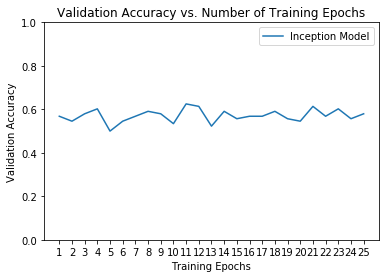

In [14]:
ohist = [h.cpu().numpy() for h in hist]
num_epochs = 25
plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Inception Model")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()